In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, classification_report,accuracy_score,confusion_matrix, roc_curve, auc, roc_curve,accuracy_score,ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        seq_length = tgt.size(-1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, 1, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/results.csv')
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)

In [ ]:
df.drop('name_s', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df.drop('nuniverse', axis=1, inplace=True)

In [ ]:
scaler_number = 20000
scaler = MinMaxScaler(feature_range=(0, scaler_number))
columns_to_scale = [col for col in df.columns if col != 'stype']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [ ]:
data = pd.get_dummies(df, columns=['stype']).astype(int)
data.reset_index(drop=True, inplace=True)

In [ ]:
min_max_df = pd.DataFrame({
    'Min': data.min(),
    'Max': data.max()
}).transpose()

In [ ]:
# If you want to preserve the original column order
min_max_df = min_max_df[data.columns]
# print(min_max_df)

In [ ]:
flag = np.random.randint(0, 2, size=data.shape[0])

In [ ]:
# smote
sm = SMOTE(random_state=27)#, ratio = 1.0)
data, flag = sm.fit_resample(data, flag)

In [ ]:
encoded_data_train, remaining_data_test, flag_train, remaining_flag_test = train_test_split(
    data, flag, train_size=0.7, random_state=42)

In [ ]:
encoded_data_test, encoded_data_val, flag_test, flag_val = train_test_split(
    remaining_data_test, remaining_flag_test, test_size=0.5, random_state=42)

In [ ]:
encoded_data_train = torch.Tensor(encoded_data_train.to_numpy())

encoded_data_train = torch.tensor(encoded_data_train, dtype=torch.long)
flag_train = torch.tensor(flag_train, dtype=torch.long)

<ipython-input-116-da1e66198b9b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_data_train = torch.tensor(encoded_data_train, dtype=torch.long)


In [ ]:
encoded_data_test = torch.Tensor(encoded_data_test.to_numpy())

encoded_data_test = torch.tensor(encoded_data_test, dtype=torch.long)
flag_test = torch.tensor(flag_test, dtype=torch.long)

<ipython-input-117-747c74d9a1bb>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_data_test = torch.tensor(encoded_data_test, dtype=torch.long)


In [ ]:
encoded_data_val = torch.Tensor(encoded_data_val.to_numpy())

encoded_data_val = torch.tensor(encoded_data_val, dtype=torch.long)
flag_val = torch.tensor(flag_val, dtype=torch.long)

<ipython-input-118-29bb348866bd>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_data_val = torch.tensor(encoded_data_val, dtype=torch.long)


In [ ]:
src_vocab_size = scaler_number + 1
tgt_vocab_size = 2
d_model = 128
num_heads = 1
num_layers = 2
d_ff = 32
max_seq_length = 48
dropout = 0.1
epoch_num = 30

In [ ]:
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
train_losses = []
val_losses = []
test_losses = []

In [ ]:
transformer.train()
for epoch in range(epoch_num):
    optimizer.zero_grad()
    output = transformer(encoded_data_train, flag_train.unsqueeze(1))
    flag_train_dim = torch.cat((1 - flag_train.view(-1, 1), flag_train.view(-1, 1)), dim=1)
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), flag_train_dim.float())
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # train_accuracy = accuracy_score(output.contiguous().view(-1, tgt_vocab_size), flag_train_dim.float())
    # train_accuracies.append(train_accuracy)
    print(f"Epoch: {epoch + 1}, Loss: {loss.item()})") # , Training Accuracy: {train_accuracy:.4f}")

    if (epoch + 1) % 10 == 0:
        transformer.eval()
        with torch.no_grad():
            val_output = transformer(encoded_data_val, flag_val.unsqueeze(1))
            val_flag_dim = torch.cat((1 - flag_val.view(-1, 1), flag_val.view(-1, 1)), dim=1)
            val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_flag_dim.float())
            val_losses.append(val_loss.item())
            # val_accuracy = accuracy_score(val_output.contiguous().view(-1, tgt_vocab_size), val_flag_dim.float())
            # val_accuracies.append(val_accuracy)
            print(f"Epoch: {epoch + 1}, Validation Loss: {loss.item()}") #, Validation Accuracy: {train_accuracy:.4f}")

        transformer.train()

Epoch: 1, Loss: 0.7278158068656921)
Epoch: 2, Loss: 0.6810393929481506)
Epoch: 3, Loss: 0.6367959380149841)
Epoch: 4, Loss: 0.5973204970359802)
Epoch: 5, Loss: 0.5599190592765808)
Epoch: 6, Loss: 0.5272093415260315)
Epoch: 7, Loss: 0.4970846474170685)
Epoch: 8, Loss: 0.47001713514328003)
Epoch: 9, Loss: 0.44236308336257935)
Epoch: 10, Loss: 0.4149581789970398)
Epoch: 10, Validation Loss: 0.4149581789970398
Epoch: 11, Loss: 0.39151036739349365)
Epoch: 12, Loss: 0.36700499057769775)
Epoch: 13, Loss: 0.34174248576164246)
Epoch: 14, Loss: 0.3202223777770996)
Epoch: 15, Loss: 0.298328161239624)
Epoch: 16, Loss: 0.27844980359077454)
Epoch: 17, Loss: 0.2584841549396515)
Epoch: 18, Loss: 0.24128006398677826)
Epoch: 19, Loss: 0.22422964870929718)
Epoch: 20, Loss: 0.2081281542778015)
Epoch: 20, Validation Loss: 0.2081281542778015
Epoch: 21, Loss: 0.1937023550271988)
Epoch: 22, Loss: 0.1800953596830368)
Epoch: 23, Loss: 0.1680223047733307)
Epoch: 24, Loss: 0.15618865191936493)
Epoch: 25, Loss: 0.

In [ ]:
transformer.eval()
with torch.no_grad():
    test_output = transformer(encoded_data_test, flag_test.unsqueeze(1))
    test_flag_dim = torch.cat((1 - flag_test.view(-1, 1), flag_test.view(-1, 1)), dim=1)
    test_loss = criterion(test_output.contiguous().view(-1, tgt_vocab_size), test_flag_dim.float())
    test_losses.append(test_loss.item())
    # test_accuracy = accuracy_score(test_output.contiguous().view(-1, tgt_vocab_size), test_flag_dim.float())
    print(f"Testing Loss: {test_loss.item()}") #, Testing Accuracy: {test_accuracy:.4f}")

Testing Loss: 0.07135450094938278


In [ ]:
from sklearn.metrics import classification_report

# Convert output probabilities to binary predictions
predicted_classes = torch.round(torch.sigmoid(test_output)).squeeze().cpu().numpy()
if predicted_classes.ndim > 1:
    predicted_classes = np.argmax(predicted_classes, axis=1)

# Convert true classes to binary indicators
true_classes = flag_test.cpu().numpy()

# Classification report
report = classification_report(true_classes, predicted_classes)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1042
           1       1.00      1.00      1.00      1068

    accuracy                           1.00      2110
   macro avg       1.00      1.00      1.00      2110
weighted avg       1.00      1.00      1.00      2110



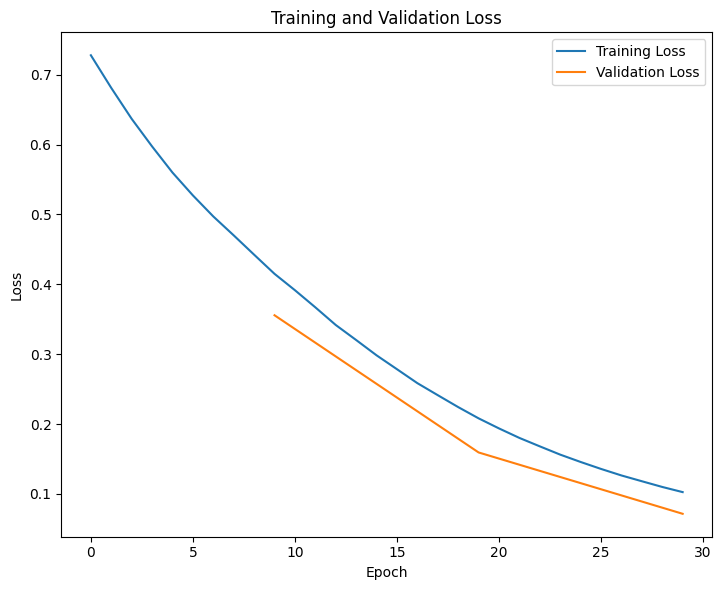

In [ ]:
plt.figure(figsize=(14, 6))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(range(9, epoch_num, 10), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()